<a href="https://colab.research.google.com/github/Abritty/3-1-project/blob/master/PCA%2BICA%2BSVM_IP_OA_Kappa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spectral 
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

     |████████████████████████████████| 215kB 5.3MB/s 


In [8]:
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [9]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [10]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [11]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
  #q=np.reshape(X, (X.shape[0]*X.shape[1],X.shape[2]))
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)

df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band162,band163,band164,band165,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [12]:
pca = PCA(n_components = 40)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,41)]+['class']

q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12,PC-13,PC-14,PC-15,PC-16,PC-17,PC-18,PC-19,PC-20,PC-21,PC-22,PC-23,PC-24,PC-25,PC-26,PC-27,PC-28,PC-29,PC-30,PC-31,PC-32,PC-33,PC-34,PC-35,PC-36,PC-37,PC-38,PC-39,PC-40,class
0,5014.905985,1456.863260,72.697049,71.204926,-435.686986,-68.840293,134.809841,-304.372408,256.433061,-66.630873,-122.609580,-29.204945,-121.087687,174.848983,-148.582847,157.036839,-51.369379,409.148533,-223.373755,8.020904,39.696815,-118.476655,-119.002956,47.662819,109.991117,-74.793846,49.913690,-53.894394,-6.561637,-15.115310,27.135600,20.687781,-2.546403,19.931357,-19.717057,-32.831597,-26.272269,-0.361401,65.249388,6.479700,3
1,5601.383743,-2023.450087,350.134660,-528.465053,148.088297,-288.359013,202.956818,240.848066,-474.857855,93.493908,302.630777,-8.494000,-78.950384,31.234521,67.001830,-42.587126,-127.627164,-136.376826,168.169846,38.700980,35.971623,-13.588638,103.034460,41.420844,-123.734398,-43.676306,162.929682,-67.173653,-217.387244,427.688041,-72.478348,102.834086,-80.036819,-51.188954,29.158798,12.011971,20.243943,3.865388,16.316901,38.693940,3
2,5796.135442,-3090.394852,490.539929,-760.214347,259.933306,-131.611181,172.927285,205.911225,572.491944,-191.622059,404.008316,-58.675388,-22.358932,-78.583570,-46.956833,55.017253,-141.365375,-217.394411,105.473127,-22.122841,-5.786856,10.258459,150.948594,109.544048,-157.842966,-136.347720,118.601296,30.551535,103.608682,-7.680559,55.760870,35.988891,-36.252935,-14.127423,20.352992,36.142406,16.963297,22.886496,-33.864078,84.162736,3
3,5586.204575,-2369.376085,356.274719,-502.687155,146.554951,-306.679320,251.071053,234.966473,-314.023199,54.962356,328.634126,35.040674,-46.570894,20.722265,146.114384,6.821877,-24.161770,-120.265749,157.079910,20.097444,13.047118,20.433695,110.250861,83.114123,-112.811016,-20.305499,171.808426,-85.281585,-207.961186,379.219602,-86.355972,130.358654,-64.400658,33.499532,20.351883,65.296837,9.002071,49.817850,2.358609,54.097105,3
4,5020.990792,339.603390,-23.007525,-92.556769,-368.495441,-438.266696,502.715401,-345.536531,-188.352653,-67.505982,-256.850162,61.321246,57.619429,30.987716,26.174199,-66.650696,134.019162,139.394779,36.616967,44.409390,38.716022,-41.197092,-28.146798,49.817147,9.465985,-30.453489,92.163965,-51.558209,35.462967,38.262533,14.986767,-82.496613,72.364679,182.048845,-8.054242,-17.591945,11.421410,-2.154118,63.782351,17.265379,3


In [14]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components = 40,max_iter=1000, tol=0.005)
dt = ica.fit_transform(q.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'IC-{i}' for i in range(1,41)]+['class']

q.head()

,IC-1,IC-2,IC-3,IC-4,IC-5,IC-6,IC-7,IC-8,IC-9,IC-10,IC-11,IC-12,IC-13,IC-14,IC-15,IC-16,IC-17,IC-18,IC-19,IC-20,IC-21,IC-22,IC-23,IC-24,IC-25,IC-26,IC-27,IC-28,IC-29,IC-30,IC-31,IC-32,IC-33,IC-34,IC-35,IC-36,IC-37,IC-38,IC-39,IC-40,class
0,-0.002388,0.001444,0.001168,0.001300,-0.000726,0.002362,-0.000668,0.005362,-0.003372,0.001275,0.000147,0.002264,-0.000696,-0.002756,0.000366,0.000758,0.003672,0.000962,0.009073,0.017758,-0.001032,0.002020,-0.002152,9.635769e-08,0.001145,0.002155,-0.000191,0.001965,0.000743,-0.002263,0.005042,0.000076,0.003254,-0.003226,-0.002185,-0.001892,0.002988,0.001799,-0.000191,0.000297,3
1,0.002185,0.001886,0.002429,-0.000087,-0.007215,0.001821,-0.001098,0.000139,-0.002205,0.000738,0.002939,-0.001573,0.002683,-0.001729,-0.000561,-0.029728,-0.001339,-0.000352,0.007797,-0.010479,0.000641,0.003440,-0.002543,-8.474986e-04,0.001506,0.002550,-0.004072,-0.002522,-0.000314,0.003266,-0.007178,-0.001715,-0.009142,-0.002036,0.002089,0.001407,0.000460,0.000902,0.001563,0.001459,3
2,0.002692,0.002055,-0.000607,0.003049,-0.009387,0.000619,-0.002279,-0.001147,-0.003564,-0.001169,0.004149,-0.002344,-0.001010,-0.003415,0.000474,0.000419,-0.000440,-0.000254,0.006652,-0.008514,0.000472,0.003369,-0.002766,1.617063e-05,0.002335,0.001107,-0.003477,-0.005131,0.001189,0.005555,-0.007085,-0.000135,0.012210,-0.001279,0.015944,0.001903,0.000174,0.001385,0.002063,-0.000418,3
3,0.003076,0.002674,-0.001085,0.002999,-0.006085,0.001177,-0.001872,-0.001423,-0.004398,-0.002302,0.002614,0.000187,0.003790,-0.002333,0.000536,-0.027314,0.001762,0.000356,0.006284,-0.010522,-0.000167,0.002928,-0.001510,-6.609903e-04,0.002142,0.001536,-0.006623,-0.001917,0.000072,0.004381,-0.006663,0.001578,-0.006800,-0.003902,0.002600,0.002050,0.001288,0.001991,0.002424,0.002605,3
4,-0.002212,-0.000699,0.002506,0.003450,-0.000938,0.000674,-0.001632,-0.000970,-0.003180,0.002063,-0.000936,-0.000149,-0.000227,-0.002320,0.000738,0.001091,0.004459,0.002321,0.003672,0.004643,-0.000778,0.001675,0.000054,-2.292844e-03,0.001099,0.002133,-0.002445,-0.000375,0.001223,0.010207,0.008342,-0.000199,-0.006297,-0.013713,-0.003176,0.001447,0.000970,0.002797,0.000714,0.002833,3


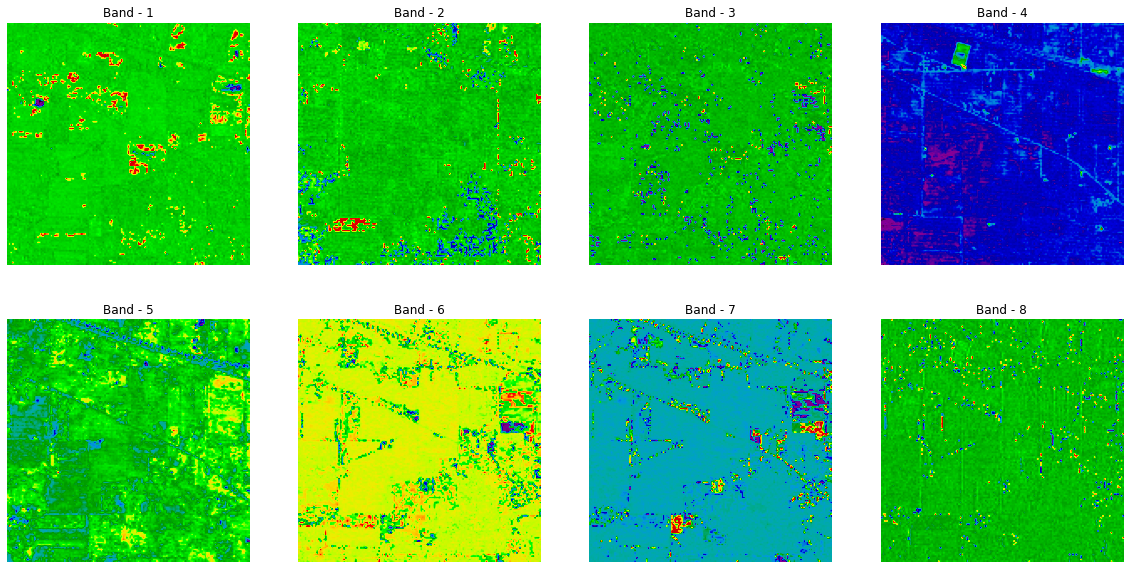

In [16]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'IC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('IP_PCA+ICA_Bands1.png')

In [17]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn

In [18]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)

svm.fit(X_train, y_train)

ypred = svm.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, ypred)
print(accuracy)

0.8390243902439024


In [26]:
names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']

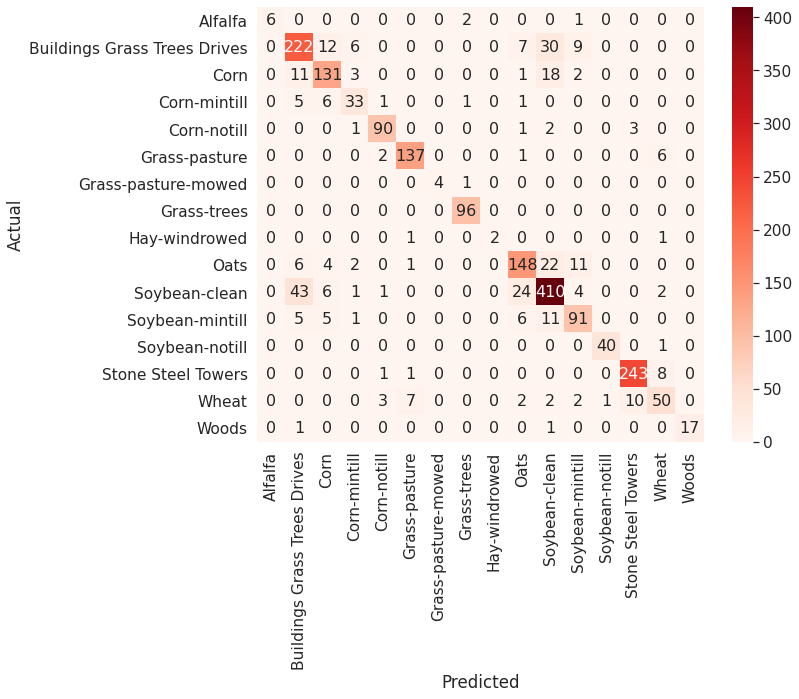

In [27]:
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [28]:
print(classification_report(y_test, ypred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.67      0.80         9
                 Corn-notill       0.76      0.78      0.77       286
                Corn-mintill       0.80      0.79      0.79       166
                        Corn       0.70      0.70      0.70        47
               Grass-pasture       0.92      0.93      0.92        97
                 Grass-trees       0.93      0.94      0.94       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.96      1.00      0.98        96
                        Oats       1.00      0.50      0.67         4
              Soybean-notill       0.77      0.76      0.77       194
             Soybean-mintill       0.83      0.84      0.83       491
               Soybean-clean       0.76      0.76      0.76       119
                       Wheat       0.98      0.98      0.98        41
                   

In [ ]:

    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

In [30]:
oa = accuracy_score(y_test, ypred)
print(oa)

0.8390243902439024


In [32]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [33]:
confusion = confusion_matrix(y_test, ypred)
each_acc, aa = AA_andEachClassAccuracy(confusion)

In [34]:
print(aa)

0.8089475331840006


In [37]:
    kappa = cohen_kappa_score(y_test, ypred)

    print("Kappa",kappa)
 


Kappa 0.8162554074281705


In [38]:
l=[]
for i in range(q.shape[0]):
  if q.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(svm.predict(q.iloc[i, :-1].values.reshape(1, -1)))

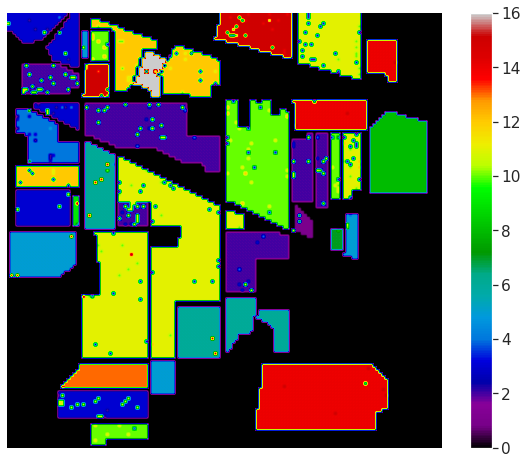

In [39]:
clmap = np.array(l).reshape(145, 145).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()